# Imports

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split

import constants.constants as cst
from src.preprocessing import preprocess_data
from src.utils.calibration import plot_calibration_curve
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.model_utils import save_model
from src.utils.plot_roc import plot_roc_curve


# Load Data

In [47]:
data = load_data()
X = data.drop(columns=cst.TARGET)
y = data[cst.TARGET]

# Model

## Base Logistic Regression

In [48]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [49]:
preprocessed_train_data, y_train, preprocessor = preprocess_data(train_data, fit=True)

preprocessed_test_data, y_test, _ = preprocess_data(
    test_data, preprocessor=preprocessor, fit=False
)

2025-10-25 19:05:43.294 | INFO     | src.preprocessing:preprocess_data:62 - No preprocessor provided. Creating a new one.
2025-10-25 19:05:43.295 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-25 19:05:43.298 | INFO     | src.preprocessing:preprocess_data:77 - Fitting and transforming data.
2025-10-25 19:05:43.332 | INFO     | src.utils.model_utils:save_model:39 - Model saved to: /home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/models/preprocessor.pkl
2025-10-25 19:05:43.333 | INFO     | src.preprocessing:preprocess_data:80 - Preprocessor fitted and saved.
2025-10-25 19:05:43.334 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-25 19:05:43.335 | INFO     | src.preprocessing:preprocess_data:82 - Transforming data with existing preprocessor.


In [50]:
## Model - Logistic Regression
model_baseline = LogisticRegression()
model_baseline.fit(preprocessed_train_data, y_train)

# Make predictions
y_pred_proba_baseline = model_baseline.predict_proba(preprocessed_test_data)[:, 1]

In [51]:
threshold = 0.5
y_pred_baseline = (y_pred_proba_baseline >= threshold).astype(int)

### Evaluation

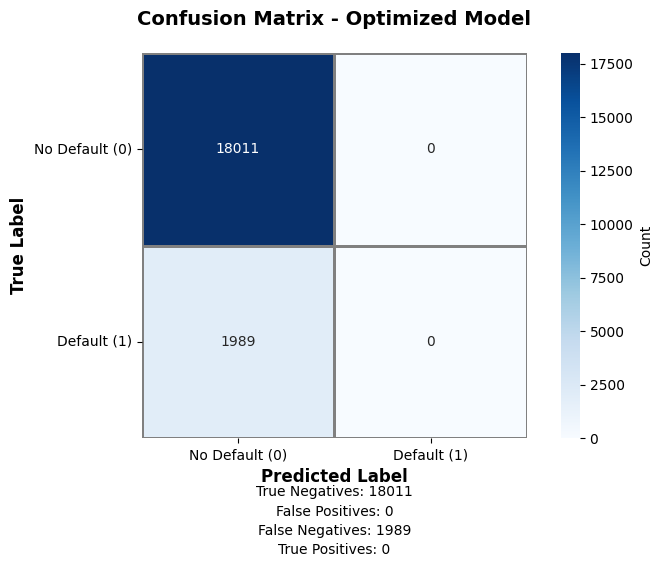


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [52]:
plot_confusion_matrix(y_test, y_pred_baseline, cmap="Blues")

In [53]:
# Feature importance (if model supports it)
if hasattr(model_baseline, "feature_importances_"):
    feature_names = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame(
        {"feature": feature_names, "importance": model_baseline.feature_importances_}
    ).sort_values("importance", ascending=False)

    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df.head(15)["feature"], importance_df.head(15)["importance"])
    plt.xlabel("Importance")
    plt.title("Top 15 Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(model_baseline, "coef_"):
    feature_names = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame(
        {"feature": feature_names, "coefficient": np.abs(model_baseline.coef_[0])}
    ).sort_values("coefficient", ascending=False)

    print("\nTop 10 Most Important Features (by coefficient magnitude):")
    print(importance_df.head(10))


Top 10 Most Important Features (by coefficient magnitude):
                      feature  coefficient
4     cat__employment_student     0.807459
0                 num__income     0.737312
5  cat__employment_unemployed     0.473479
1                num__signal2     0.246069
3     cat__employment_retired     0.176139
2                  cat__sex_M     0.064381
6              cat__married_1     0.026705


In [54]:
# Cross-validation score
cv_scores = cross_val_score(
    model_baseline, preprocessed_train_data, y_train, cv=5, scoring="f1"
)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation F1 scores: [0. 0. 0. 0. 0.]
Mean CV F1: 0.0000 (+/- 0.0000)


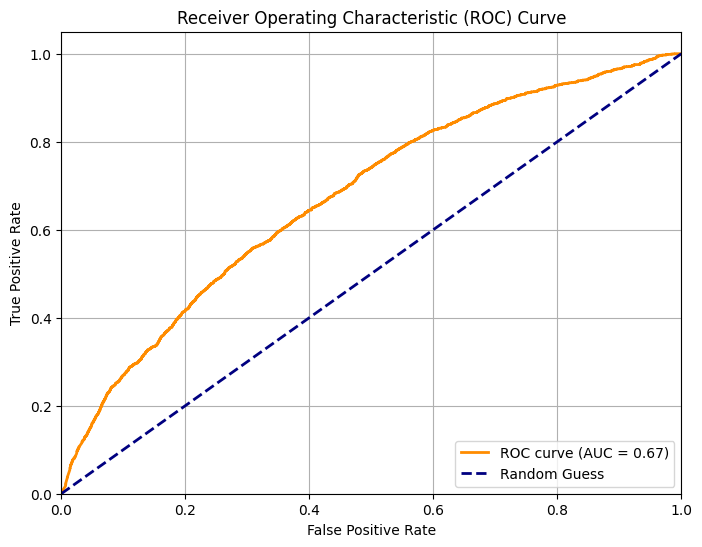

In [55]:
# Plot ROC curve
plot_roc_curve(y_test, y_pred_proba_baseline)

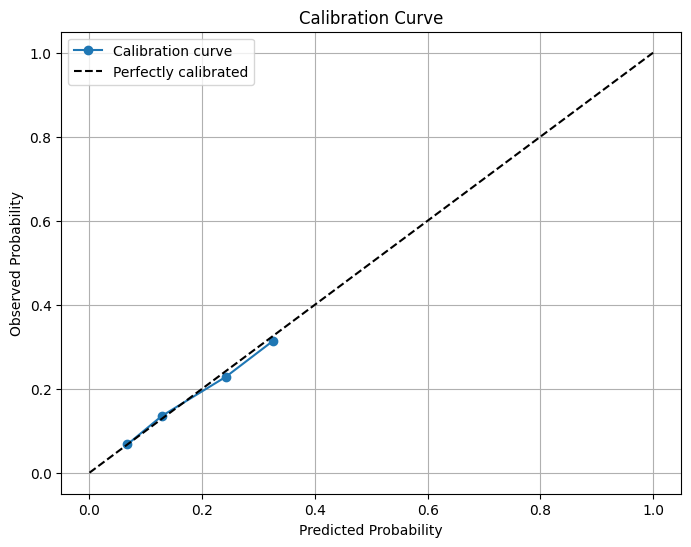

In [56]:
plot_calibration_curve(y_test, y_pred_proba_baseline)

## Hyperparameter fine-tuning (Optuna)

In [57]:
cv_splits = 5
n_trials = 200

In [58]:
def objective(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)  # Regularization strength
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        solver = "liblinear"
    elif penalty == "elasticnet":
        solver = "saga"
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    else:
        l1_ratio = None

    # Create and train the model
    if penalty == "elasticnet":
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter,
            l1_ratio=l1_ratio,
            random_state=42,
        )
    else:
        model = LogisticRegression(
            C=C, penalty=penalty, solver=solver, max_iter=max_iter, random_state=42
        )

    # Use cross-validation on TRAINING data only (more robust than single split)
    cv_scores = cross_val_score(
        model,
        preprocessed_train_data,
        y_train,
        cv=cv_splits,  # 5-fold cross-validation
        scoring="f1",  # or 'roc_auc', 'accuracy', etc.
        n_jobs=-1,  # Use all CPU cores
    )

    return cv_scores.mean()


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-25 19:05:44,270] A new study created in memory with name: no-name-5a0fe07c-00bd-406f-a6c1-fa47cb3aacc6


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-10-25 19:05:44,674] Trial 0 finished with value: 0.0 and parameters: {'C': 7.558527850156426, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 659}. Best is trial 0 with value: 0.0.
[I 2025-10-25 19:05:44,966] Trial 1 finished with value: 0.0 and parameters: {'C': 0.0007738343865377784, 'penalty': 'elasticnet', 'solver': 'liblinear', 'max_iter': 131, 'l1_ratio': 0.23989554536375923}. Best is trial 0 with value: 0.0.
[I 2025-10-25 19:05:45,209] Trial 2 finished with value: 0.0 and parameters: {'C': 74.12409737705937, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 568}. Best is trial 0 with value: 0.0.
[I 2025-10-25 19:05:45,401] Trial 3 finished with value: 0.0 and parameters: {'C': 0.0005345924956393362, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 385}. Best is trial 0 with value: 0.0.
[I 2025-10-25 19:05:45,737] Trial 4 finished with value: 0.0 and parameters: {'C': 0.009062784798834376, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 275}. Best is trial 0 with value

In [59]:
# Train the final model with best parameters
best_params = study.best_params.copy()

if best_params.get("penalty") == "elasticnet":
    model_optimized = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        l1_ratio=best_params.get("l1_ratio"),
        class_weight="balanced",
        random_state=42,
    )
else:
    model_optimized = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        class_weight="balanced",
        random_state=42,
    )

model_optimized.fit(preprocessed_train_data, y_train)

# Make predictions on test set
y_pred_proba_optimized = model_optimized.predict_proba(preprocessed_test_data)[:, 1]

thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = [
    f1_score(y_test, (y_pred_proba_optimized >= t).astype(int)) for t in thresholds
]
optimal_threshold = thresholds[np.argmax(f1_scores)]

y_pred_optimized = (y_pred_proba_optimized >= optimal_threshold).astype(int)

print(f"Optimal threshold on test set: {optimal_threshold:.3f}")
print(f"Test F1-Score: {max(f1_scores):.4f}")

Optimal threshold on test set: 0.520
Test F1-Score: 0.2594


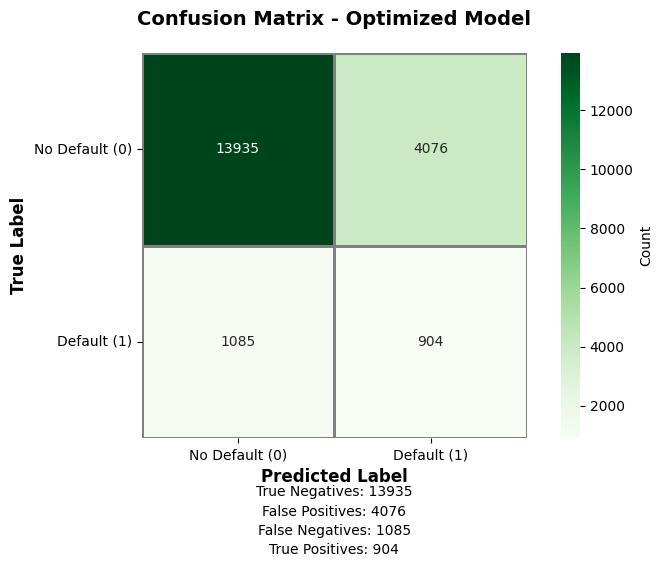


Model Metrics:
Accuracy:  0.7419 (74.19%)
Precision: 0.1815 (18.15%)
Recall:    0.4545 (45.45%)
F1-Score:  0.2594 (25.94%)


In [60]:
plot_confusion_matrix(y_test, y_pred_optimized, cmap="Greens")

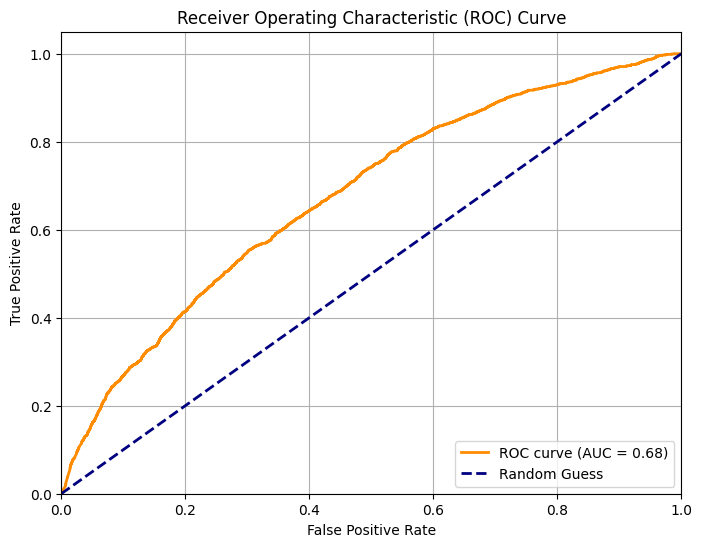

In [61]:
# ROC curve for optimized model
plot_roc_curve(y_test, y_pred_proba_optimized)

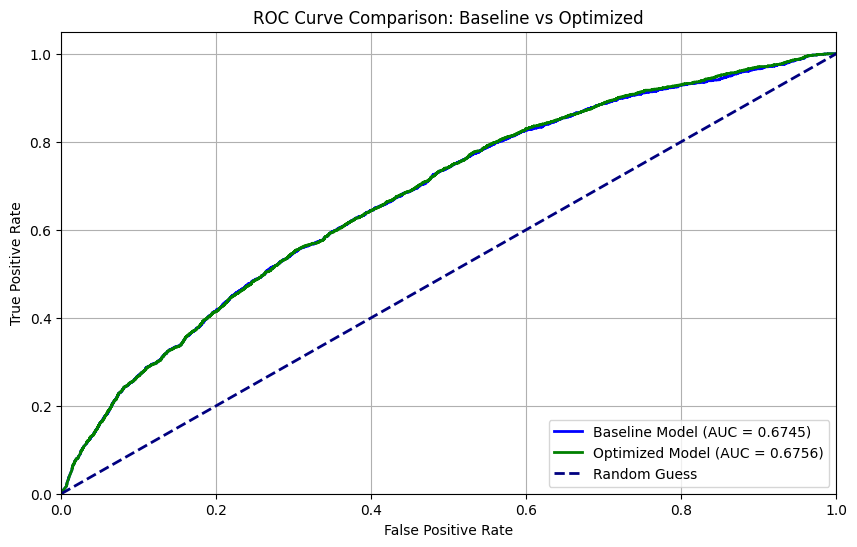

Baseline AUC: 0.6745
Optimized AUC: 0.6756
Improvement: 0.0011 (0.17%)


In [62]:
# Compare both models side by side
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curves for both models
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

# Plot both on the same figure
plt.figure(figsize=(10, 6))
plt.plot(
    fpr_baseline,
    tpr_baseline,
    color="blue",
    lw=2,
    label=f"Baseline Model (AUC = {auc_baseline:.4f})",
)
plt.plot(
    fpr_optimized,
    tpr_optimized,
    color="green",
    lw=2,
    label=f"Optimized Model (AUC = {auc_optimized:.4f})",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Baseline vs Optimized")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Baseline AUC: {auc_baseline:.4f}")
print(f"Optimized AUC: {auc_optimized:.4f}")
print(
    f"Improvement: {auc_optimized - auc_baseline:.4f} ({((auc_optimized - auc_baseline) / auc_baseline * 100):.2f}%)"
)

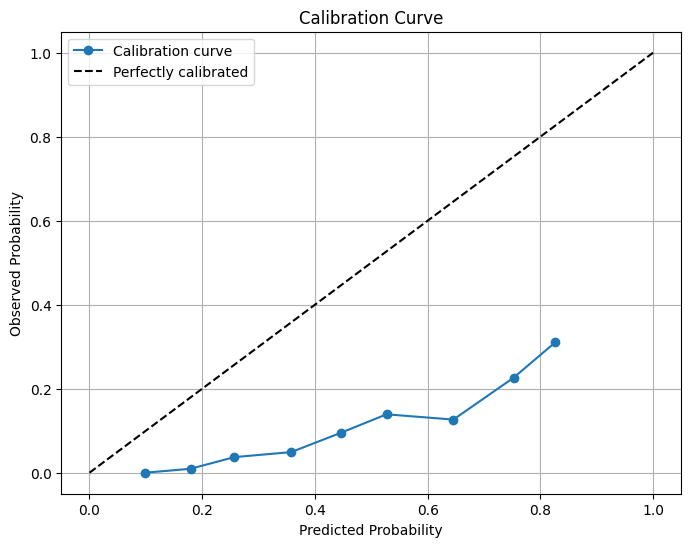

In [63]:
plot_calibration_curve(y_test, y_pred_proba_optimized)

In [64]:
# Calibrate the optimized model

model_calibrated = CalibratedClassifierCV(
    model_optimized, method="isotonic", cv="prefit"
)
model_calibrated.fit(preprocessed_train_data, y_train)

y_pred_proba_calibrated = model_calibrated.predict_proba(preprocessed_test_data)[:, 1]


# Find optimal threshold on test set
thresholds = np.arange(0, 1, 0.01)
f1_scores = [
    f1_score(y_test, (y_pred_proba_calibrated >= t).astype(int)) for t in thresholds
]
calibrated_threshold = thresholds[np.argmax(f1_scores)]

y_pred_calibrated = (y_pred_proba_calibrated >= calibrated_threshold).astype(int)

/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


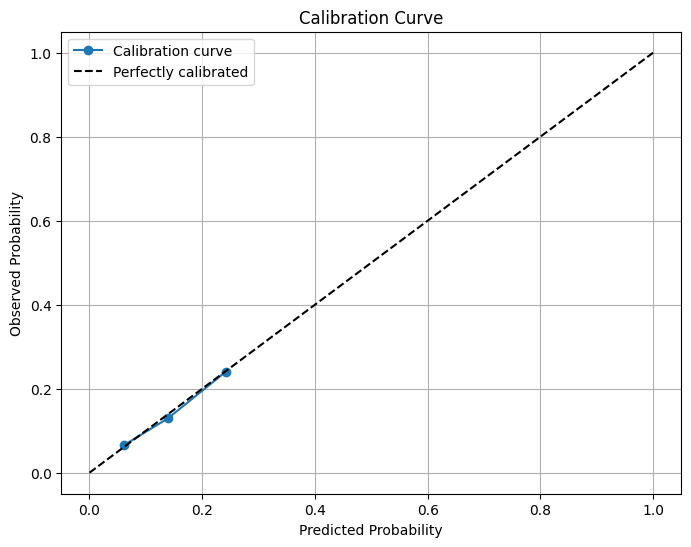

In [65]:
plot_calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

In [66]:
compute_and_store_metrics(
    y_test, y_pred_optimized, model_name="LogisticRegression_Optimized"
)

compute_and_store_metrics(
    y_test, y_pred_calibrated, model_name="LogisticRegression_Calibrated"
)


In [67]:
# Final training on the entire dataset
# Preprocess full dataset
full_data = pd.concat([X, y], axis=1)
preprocessed_full_data, y_full, final_preprocessor = preprocess_data(
    full_data, fit=True
)

if best_params.get("penalty") == "elasticnet":
    final_model = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        l1_ratio=best_params.get("l1_ratio"),
        class_weight="balanced",
        random_state=42,
    )
else:
    final_model = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        class_weight="balanced",
        random_state=42,
    )

final_model.fit(preprocessed_full_data, y_full)

# Calibrate final model
model_calibrated_final = CalibratedClassifierCV(
    final_model, method="isotonic", cv="prefit"
)
model_calibrated_final.fit(preprocessed_full_data, y_full)


# Save both model and preprocessor
save_model(model_calibrated_final, model_name="LogisticRegression_Calibrated_Optimized")
save_model(
    final_preprocessor,
    model_name="LogisticRegression_Calibrated_Optimized_preprocessor",
)

print(f"✓ Model trained on full dataset ({len(y_full)} samples)")
print(f"✓ Model saved with calibrated threshold: {calibrated_threshold:.3f}")

2025-10-25 19:06:56.719 | INFO     | src.preprocessing:preprocess_data:62 - No preprocessor provided. Creating a new one.
2025-10-25 19:06:56.720 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-25 19:06:56.724 | INFO     | src.preprocessing:preprocess_data:77 - Fitting and transforming data.
2025-10-25 19:06:56.773 | INFO     | src.utils.model_utils:save_model:39 - Model saved to: /home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/models/preprocessor.pkl
2025-10-25 19:06:56.773 | INFO     | src.preprocessing:preprocess_data:80 - Preprocessor fitted and saved.
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
2025-10-25 19:06:58.040 | INFO     | src.utils

✓ Model trained on full dataset (100000 samples)
✓ Model saved with calibrated threshold: 0.150
